### Import Packages


In [ ]:
import os
import csv
import numpy as np
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.__version__)

1.12.1+cu113


In [ ]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

### Let's load the Flowers102 dataset


In [ ]:
data_path = './Flowers'
batch_size = 256

my_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(224),
    torchvision.transforms.CenterCrop((224, 224)),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    )

train_dataset = torchvision.datasets.Flowers102(data_path, 'train', transform= my_transform, download=True)
test_dataset = torchvision.datasets.Flowers102(data_path, 'test', transform= my_transform, download=True)
train_dataloader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Choose your device - use GPU or not?

In [ ]:
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Current Device : {}'.format(device))

Current Device : cuda


### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
# sample = test_dataset[1]
print(sample[0].shape)
print(sample[1])

torch.Size([256, 3, 224, 224])
tensor([ 72,  85,   1,  53,  79,  53,  19,  91,  91,  20,   7,  72,  84,  41,
         24,  34,  22,  38,  25,  74,  48,  40,  32,  76,  56,  91,  80,  51,
          6,  49,   0,  28,  58,  46,   1,  23,  51,  59,  10,  11,  37,  36,
         54,  69,  16,  87,  28,  10,  90,  89,  85,  71,   3,  17,  75,  91,
         40,  49,  22,  33,  29,  24,  20,  79,  41,   0,  27,  51,  72, 100,
         85,  39,  52,  14,  77,   3,  87,  22,  61,  98,  99,  22,  58,  71,
         66,  54,  43,  42,  53,  93,  49,  81,  53,  92,  60,  66,  46,  15,
         29,  74,  72,  35,  84,  87,  67,  94,  24,  28,  80,  60,  91,   5,
        100,  84,   9,   3,  61,  78,  87,  10, 100,  22,  83,   1,   8,  82,
         68,  94,  80,  74,  46,   6,  44,   4,  61,  47,  24,  26,  43,   4,
         13,  27,  94,  23,  89,  27,   8,  52,  53,   1,  79, 100,  80,  19,
         96,  15,  38,  95,  17,  92,  80,  35,  17,  83,  26,  45,  32,  86,
         64,  69,  69,  72,  21, 

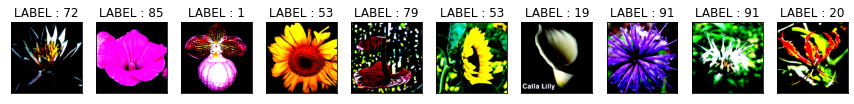

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample[0][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample[1][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

### Define the ResNet Based Model

In [ ]:
class ResNets(nn.Module):
    def __init__(self, dim_output=102):
        super(ResNets, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

        for p in self.resnet.parameters():
            p.requires_grad = False

        for p in list(self.resnet.layer4.parameters()):
            p.requires_grad = True

        self.resnet.fc = nn.Linear(2048, dim_output)
        
    def forward(self, img):
        return self.resnet(img)


# class new_model(nn.Module):
#     def __init__(self, output_layer):
#         super().__init__()
#         self.output_layer = output_layer
#         self.pretrained = models.resnet18(pretrained=True)
#         self.children_list = []
#         for n,c in self.pretrained.named_children():
#             self.children_list.append(c)
#             if n == self.output_layer:
#                 break

#         self.net = nn.Sequential(*self.children_list)
#         self.pretrained = None
        
#     def forward(self,x):
#         x = self.net(x)
#         return x

### Define the Model

In [ ]:
model = ResNets()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

print(model)

ResNets(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()

    criterion = nn.CrossEntropyLoss()

    optimizer.zero_grad()

    img = sample[0].float().to(device)
    label = sample[1].long().to(device) 
    
    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    
    pred_loss = criterion(pred, label)
    
    # Try to add the regularization loss!

    pred_loss.backward()
       
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        img = sample[0].float().to(device)
        label = sample[1].long().to(device) 

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
max_epoch = 200
tmp_path = './checkpoint.pth'

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    torch.save(model.state_dict(), 'recent.pth')
    
    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataset)


    print('[epoch {}] Loss train: {:.02f} test:{:.02f} / Accu train: {:.02f} test:{:.02f}'.format(epoch+1, train_loss, test_loss, train_accu, test_accu))

  0%|          | 0/200 [00:00<?, ?it/s]

[epoch 1] Loss train: 4.62 test:4.60 / Accu train: 0.01 test:0.01
[epoch 2] Loss train: 4.43 test:4.51 / Accu train: 0.21 test:0.05
[epoch 3] Loss train: 4.22 test:4.38 / Accu train: 0.54 test:0.17
[epoch 4] Loss train: 3.97 test:4.20 / Accu train: 0.77 test:0.26
[epoch 5] Loss train: 3.69 test:3.98 / Accu train: 0.89 test:0.35
[epoch 6] Loss train: 3.37 test:3.69 / Accu train: 0.95 test:0.40
[epoch 7] Loss train: 3.02 test:3.36 / Accu train: 0.97 test:0.44
[epoch 8] Loss train: 2.66 test:3.06 / Accu train: 0.97 test:0.50
[epoch 9] Loss train: 2.32 test:2.74 / Accu train: 0.98 test:0.55
[epoch 10] Loss train: 1.99 test:2.50 / Accu train: 0.99 test:0.60
[epoch 11] Loss train: 1.66 test:2.25 / Accu train: 0.99 test:0.66
[epoch 12] Loss train: 1.36 test:2.06 / Accu train: 1.00 test:0.71
[epoch 13] Loss train: 1.07 test:1.83 / Accu train: 1.00 test:0.74
[epoch 14] Loss train: 0.84 test:1.73 / Accu train: 1.00 test:0.77
[epoch 15] Loss train: 0.61 test:1.55 / Accu train: 1.00 test:0.79
[epo